# Key-Value Attention Mechanism Homework on Keras: Character-level Machine Translation (Many-to-Many, encoder-decoder)

In this homework, you will create an MT model with key-value attention mechnism that coverts names of constituency MP candidates in the 2019 Thai general election from Thai script to Roman(Latin) script. E.g. นิยม-->niyom 

In [ ]:
!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

import matplotlib as mpl
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf') # 3.2+
mpl.rc('font', family='TH Sarabun New')

--2021-03-22 03:56:14--  https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf [following]
--2021-03-22 03:56:14--  https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98308 (96K) [application/octet-stream]
Saving to: ‘thsarabunnew-webfont.ttf’

thsarabunnew-webfon 100%[===================>]  96.00K  --.-KB/s    in 0.03s   

2021-03-22 03:56:14 (3.62 MB/s) - ‘t

In [ ]:
%matplotlib inline
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
import numpy as np

import random

## Load Dataset
We have generated a toy dataset using names of constituency MP candidates in 2019 Thai General Election from elect.in.th's github(https://github.com/codeforthailand/dataset-election-62-candidates) and tltk (https://pypi.org/project/tltk/) library to convert them into Roman script.

<img src="https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/images/dataset_diagram.png" alt="Drawing" style="width: 500px;"/>


In [ ]:
!wget https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/mp_name_th_en.csv

--2021-03-22 03:56:16--  https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/mp_name_th_en.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 324399 (317K) [text/plain]
Saving to: ‘mp_name_th_en.csv’

mp_name_th_en.csv   100%[===================>] 316.80K  --.-KB/s    in 0.04s   

2021-03-22 03:56:17 (7.64 MB/s) - ‘mp_name_th_en.csv’ saved [324399/324399]



In [ ]:
import csv
with open('mp_name_th_en.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    name_th = []
    name_en = []
    for row in readCSV:
        name_th.append(row[0])
        name_en.append(row[1])

In [ ]:
for th, en in zip(name_th[:10],name_en[:10]):
    print(th,en)

ไกรสีห์ kraisi
พัชรี phatri
ธีระ thira
วุฒิกร wutthikon
ไสว sawai
สัมภาษณ์  samphat
วศิน wasin
ทินวัฒน์ thinwat
ศักดินัย sakdinai
สุรศักดิ์ surasak


## Task1: Preprocess dataset for Keras (1 point)
* 2 dictionaries for indexing (1 for input and another for output)
* DON'T FORGET TO INCLUDE special token for padding
* DON'T FORGET TO INCLUDE special token for the end of word symbol (output)
* Be mindful of your pad_sequences "padding" hyperparameter. Choose wisely (post-padding vs pre-padding)

In [ ]:
#FILL YOUR CODE HERE

input_chars = list(set(''.join(name_th)))
output_chars = list(set(''.join(name_en)))

sorted_input_chars= sorted(input_chars)
sorted_output_chars= sorted(output_chars)

sorted_input_chars.insert(0,"<PAD>") #PADDING for input
sorted_output_chars.insert(0,"<PAD>") #PADDING for output

sorted_output_chars.insert(len(sorted_output_chars),"</S>") #end of word for output

#Input
input_char_to_ix = { ch:i for i,ch in enumerate(sorted_input_chars) }
ix_to_input_char = { i:ch for i,ch in enumerate(sorted_input_chars) } #reverse dictionary
#Output
output_char_to_ix = { ch:i for i,ch in enumerate(sorted_output_chars) }
ix_to_output_char = { i:ch for i,ch in enumerate(sorted_output_chars) } #reverse dictionary

print(input_char_to_ix)
print(output_char_to_ix)

{'<PAD>': 0, ' ': 1, 'ก': 2, 'ข': 3, 'ค': 4, 'ฆ': 5, 'ง': 6, 'จ': 7, 'ฉ': 8, 'ช': 9, 'ซ': 10, 'ฌ': 11, 'ญ': 12, 'ฎ': 13, 'ฏ': 14, 'ฐ': 15, 'ฑ': 16, 'ฒ': 17, 'ณ': 18, 'ด': 19, 'ต': 20, 'ถ': 21, 'ท': 22, 'ธ': 23, 'น': 24, 'บ': 25, 'ป': 26, 'ผ': 27, 'ฝ': 28, 'พ': 29, 'ฟ': 30, 'ภ': 31, 'ม': 32, 'ย': 33, 'ร': 34, 'ล': 35, 'ว': 36, 'ศ': 37, 'ษ': 38, 'ส': 39, 'ห': 40, 'ฬ': 41, 'อ': 42, 'ฮ': 43, 'ะ': 44, 'ั': 45, 'า': 46, 'ำ': 47, 'ิ': 48, 'ี': 49, 'ึ': 50, 'ื': 51, 'ุ': 52, 'ู': 53, 'เ': 54, 'แ': 55, 'โ': 56, 'ใ': 57, 'ไ': 58, '็': 59, '่': 60, '้': 61, '๊': 62, '๋': 63, '์': 64}
{'<PAD>': 0, '-': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'w': 21, 'y': 22, '</S>': 23}


In [ ]:
maxIN = len( max(name_th, key=len))
maxOUT = len( max(name_en, key=len))

X = []
for line in name_th:
    temp=[]
    for char in line:
        temp.append(input_char_to_ix[char])
    X.append(temp)
Y = []
for line in name_en:
    temp=[]
    for char in line:
        temp.append(output_char_to_ix[char])
    temp.append(output_char_to_ix["</S>"])
    Y.append(temp)    

X = pad_sequences(X, maxlen=maxIN, padding='pre')
Y = pad_sequences(Y, maxlen=maxOUT+1, padding='post')

X = to_categorical(X,len(input_char_to_ix))
X = X.reshape(len(name_th),maxIN ,len(input_char_to_ix))

Y = to_categorical(Y,len(output_char_to_ix))
Y = Y.reshape(len(name_en),maxOUT+1 ,len(output_char_to_ix))
print(X.shape,Y.shape)
print(X[0])
print(Y[0])

(10887, 20, 65) (10887, 20, 24)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

# Attention Mechanism
## Task 2: Code your own (key-value) attention mechnism (1 point)
* PLEASE READ: you DO NOT have to follow all the details in (Daniluk, et al. 2017). You just need to create a key-value attention mechanism where the "key" part of the mechanism is used for attention score calculation, and the "value" part of the mechanism is used to encode information to create a context vector.  
* Define global variables
* fill code for one_step_attention function
* Hint: use keras.layers.Lambda 
* HINT: you will probably need more hidden dimmensions than what you've seen in the demo


In [ ]:
from tensorflow.keras.activations import softmax
from tensorflow.keras.layers import Lambda
def softMaxAxis1(x):
    return softmax(x,axis=1)


In [ ]:
#These are global variables (shared layers)
## Fill your code here
## you are allowed to use code in the demo as your template.  


repeator = RepeatVector(maxIN)
concatenator = Concatenate(axis=-1)

splitter = Lambda(lambda tensor: tf.split(tensor, num_or_size_splits=2, axis=2))

#Attention function###
fattn_1 = Dense(10, activation = "tanh")
fattn_2 = Dense(1, activation = "relu")
###
activator = Activation(softMaxAxis1, name='attention_scores') 
dotor = Dot(axes = 1)

In [ ]:
def one_step_attention(a, s_prev):

    #Fill code here
    #return None # return whatever you need to complete this homework 
     # Repeat the decoder hidden state to concat with encoder hidden states

    s_prev = repeator(s_prev)
    key , value = splitter(a)
    concat = concatenator([key,s_prev])
    # attention function
    e = fattn_1(concat)
    energies =fattn_2(e)
    # calculate attention_scores (softmax)
    attention_scores = activator(energies)
    #calculate a context vector
    context = dotor([attention_scores,value])

    return context,attention_scores

## Task3: Create and train your encoder/decoder model here (1 point)
* HINT: you will probably need more hidden dimmensions than what you've seen in the demo

In [ ]:
#FILL CODE HERE
n_h = 32 #hidden dimensions for encoder 
n_s = 64 #hidden dimensions for decoder
encoder_LSTM =  Bidirectional(LSTM(n_h, return_sequences=True),input_shape=(-1, len(input_char_to_ix), n_h*2))
decoder_LSTM_cell = LSTM(n_s, return_state = True) #decoder_LSTM_cell
output_layer = Dense(len(output_char_to_ix), activation="softmax") #softmax output layer

In [ ]:
def model(Tx, Ty, n_h, n_s, vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_h -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    vocab_size -- size of the input vocab
    output_vocab_size -- size of the output vocab

    Returns:
    model -- Keras model instance
    """
    
    # Define the input of your model
    X = Input(shape=(Tx, vocab_size))
    # Define hidden state and cell state for decoder_LSTM_Cell
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = list()
    attention_score = list()
    #Encoder Bi-LSTM
    # h = Bidirectional(LSTM(n_h, return_sequences=True),input_shape=(-1, Tx, n_h*2))(X)
    h = encoder_LSTM(X)
    #Iterate for Ty steps (Decoding)
    for t in range(Ty):
    
        #Perform one step of the attention mechanism to calculate the context vector at timestep t
        context,attention = one_step_attention(h, s)
        attention_score.append(attention)
        # Feed the context vector to the decoder LSTM cell
        s, _, c = decoder_LSTM_cell(context,initial_state=[s,c])
           
        # Pass the decoder hidden output to the output layer (softmax)
        out = output_layer(s)
        
        # Append an output list with the current output
        outputs.append(out)
    
    #Create model instance
    model = Model(inputs=[X,s0,c0],outputs=outputs)
    modelPlt = Model(inputs=[X,s0,c0],outputs=[outputs,attention_score])

    return model,modelPlt

In [ ]:
#FIT YOUR MODEL HERE
model,modelPlt = model(maxIN, maxOUT+1, n_h, n_s, len(input_char_to_ix), len(output_char_to_ix))

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20, 65)]     0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 20, 64)       25088       input_1[0][0]                    
__________________________________________________________________________________________________
s0 (InputLayer)                 [(None, 64)]         0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 [(None, 20, 32), (No 0           bidirectional[0][0]              
                                                                 bidirectional[0][0]          

In [ ]:
modelPlt.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20, 65)]     0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 20, 64)       25088       input_1[0][0]                    
__________________________________________________________________________________________________
s0 (InputLayer)                 [(None, 64)]         0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 [(None, 20, 32), (No 0           bidirectional[0][0]              
                                                                 bidirectional[0][0]        

In [ ]:
opt = Adam(lr= 0.01, clipvalue=0.5)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

# Thai-Script to Roman-Script Translation
* Task 4: Test your model on 5 examples of your choice including your name! (1 point)
* Task 5: Show your visualization of attention scores on one of your example (1 point)

In [ ]:
#task 4
#fill your code here
s0 = np.zeros((len(name_th), n_s))
c0 = np.zeros((len(name_th), n_s))
outputs = list(Y.swapaxes(0,1))

In [ ]:
np.array(outputs).shape

(20, 10887, 24)

In [ ]:
model.fit([X, s0, c0], outputs, epochs=20, batch_size=120)

Epoch 1/20
91/91 [==============================] - 50s 110ms/step - loss: 31.9710 - dense_2_loss: 3.1490 - dense_2_1_loss: 2.9823 - dense_2_2_loss: 3.0735 - dense_2_3_loss: 3.1446 - dense_2_4_loss: 3.1080 - dense_2_5_loss: 2.9945 - dense_2_6_loss: 2.7229 - dense_2_7_loss: 2.2235 - dense_2_8_loss: 1.6880 - dense_2_9_loss: 1.2582 - dense_2_10_loss: 0.9449 - dense_2_11_loss: 0.7216 - dense_2_12_loss: 0.6008 - dense_2_13_loss: 0.5377 - dense_2_14_loss: 0.5004 - dense_2_15_loss: 0.4755 - dense_2_16_loss: 0.4687 - dense_2_17_loss: 0.4629 - dense_2_18_loss: 0.4579 - dense_2_19_loss: 0.4558 - dense_2_accuracy: 0.0436 - dense_2_1_accuracy: 0.1409 - dense_2_2_accuracy: 0.1112 - dense_2_3_accuracy: 0.0722 - dense_2_4_accuracy: 0.0901 - dense_2_5_accuracy: 0.1296 - dense_2_6_accuracy: 0.2169 - dense_2_7_accuracy: 0.3832 - dense_2_8_accuracy: 0.5738 - dense_2_9_accuracy: 0.7197 - dense_2_10_accuracy: 0.8133 - dense_2_11_accuracy: 0.8787 - dense_2_12_accuracy: 0.9105 - dense_2_13_accuracy: 0.9273 -

In [ ]:
def prep_input(input_list):
   X = []
   for line in input_list:
      temp=[]
      for char in line:
          temp.append(input_char_to_ix[char])
      X.append(temp)
   X = pad_sequences(X, maxlen=maxIN, padding='pre')
   X = to_categorical(X,len(input_char_to_ix))
   X = X.reshape(len(input_list),maxIN ,len(input_char_to_ix))
    
   return X

EXAMPLES = ['พลวัต', 'วุฒิกร', 'ศุภกิจ','ชวกร', 'สมชาย']
s0 = np.zeros((len(EXAMPLES), n_s))
c0 = np.zeros((len(EXAMPLES), n_s))
EXAMPLES = prep_input(EXAMPLES)

prediction = model.predict([EXAMPLES , s0, c0])
prediction = np.swapaxes(prediction,0,1)
prediction = np.argmax(prediction, axis = -1)


#Y = pad_sequences(Y, maxlen=maxOUT+1, padding='post')
for j in range(len(prediction)):
    output = "".join([ix_to_output_char[int(i)] for i in prediction[j]])
    for k in range(len(output)):
      if output[k] == "<":
        break
    print(output[:k])

phonwat
wutthikon
supphakit
chawakon
somchai


In [ ]:
EXAMPLES = ['พลวัต', 'วุฒิกร', 'ศุภกิจ','ชวกร', 'สมชาย']
s0 = np.zeros((len(EXAMPLES), n_s))
c0 = np.zeros((len(EXAMPLES), n_s))
EXAMPLES = prep_input(EXAMPLES)

prediction2 = modelPlt.predict([EXAMPLES , s0, c0])
prediction2[0] = np.swapaxes(prediction2[0],0,1)
prediction2[0] = np.argmax(prediction2[0], axis = -1)
print(np.array(prediction2[0]).shape)

prediction2[1] = np.swapaxes(prediction2[1],0,1)
print(np.array(prediction2[1]).shape)

(5, 20)
(5, 20, 20, 1)


### Plot the attention map
* If you need to install thai font: sudo apt install xfonts-thai
* this is what your visualization might look like:
<img src="https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/images/attn_viz_sample.png"  style="width: 350px;"/>

In [ ]:
#task 5
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family']='TH Sarabun New'  #you can change to other font that works for you
#fill your code here

def pltAtt(word):
    pltatt = prediction2[1][word].reshape(20,20)
    x_axis = [ix_to_input_char[int(np.argmax(i))] for i in EXAMPLES[word]]
    y_axis = [ix_to_output_char[int(i)] for i in prediction2[0][word]]
    for i in range(len(y_axis)):
      if y_axis[i]=="</S>":
        y_axis = y_axis[:i]
        pltatt = pltatt[:i,:]
        break
    return sns.heatmap(np.array(pltatt),vmin =0., vmax=1. ,xticklabels = x_axis, yticklabels = y_axis , linewidths=.1)



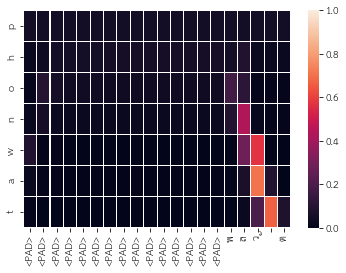

In [ ]:
pltAtt(0)

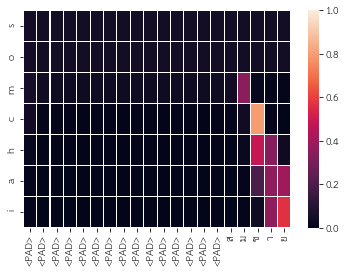

In [ ]:
pltAtt(4)